# An simple anomaly detection implementation

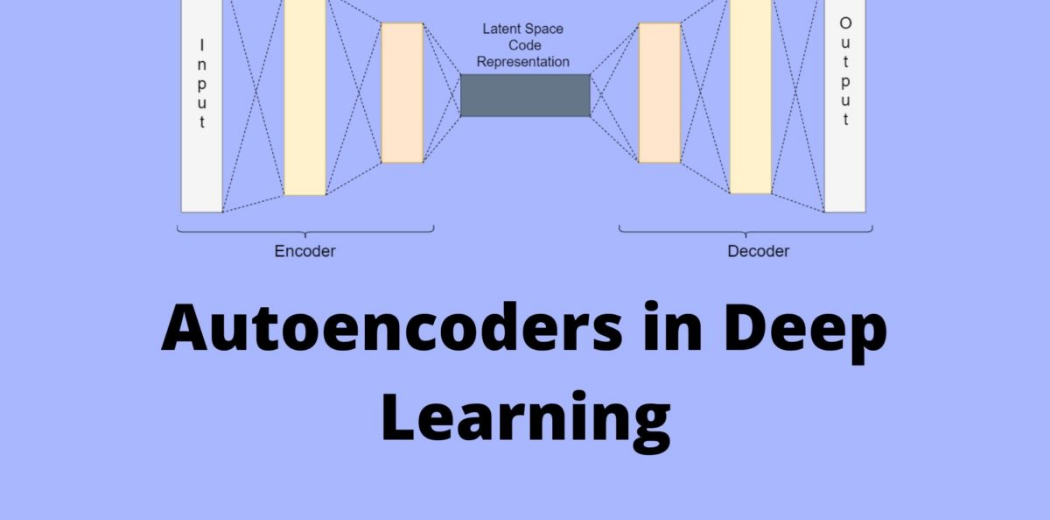

- [x] Implement an anomaly detector
- [ ] Understand the 'latent space'


In [38]:
import os
import sys

import tensorflow
import pandas
import matplotlib
import csv
import datetime
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import precision_recall_fscore_support

# Pre-process the csv file

Result data looks like, the data is aggregated to 'hour' level<br>


Hour_stamp,Day,Week_of_day,Hour,traffic<br>
2022-07-31 07,31,6,7,74847132<br>
2022-07-31 08,31,6,8,39206857<br>

In [13]:
with open('my_data.csv') as input:
    reader = csv.reader(input)
    headers = next(reader)
    print(headers)
    i = 0
    result = {}
    for row in reader:
        did = row[0]
        timestamp = row[1]
        total_bytes = row[6]
        timestamp = int(timestamp)
        traffic = int(total_bytes)
        dt_stamp = datetime.datetime.fromtimestamp(timestamp)

        hour = dt_stamp.hour
        week_day = dt_stamp.weekday()
        month_day = dt_stamp.day
        hour_string = dt_stamp.strftime("%Y-%m-%d %H")
        if did in result:
            # result[did].append([date, week_day, hour, traffic])
            did_dic = result[did]
            if hour_string in did_dic:
                did_dic[hour_string] = [did_dic[hour_string][0], did_dic[hour_string][1], did_dic[hour_string][2], did_dic[hour_string][3] + traffic]
            else:
                did_dic[hour_string] = [month_day, week_day, hour, traffic]
        else:
            result[did] = {}
            result[did][hour_string] = [month_day, week_day, hour, traffic]
    for did in result:
        with open ("%s.csv" % did, 'w') as output:
            writer = csv.writer(output, lineterminator='\n')
            writer.writerow(['Hour_stamp', 'Day', 'Week_of_day', 'Hour', 'traffic'])
            # the data is in desc order, reverse it
            temp_dic = result[did]
            keys = temp_dic.keys()
            keys = sorted(keys)
            for i in keys:
                writer.writerow([i] + temp_dic[i])
        

['device_name', 'timestamp', 'ts_hour', 'count', 'in_bytes', 'out_bytes', 'total_bytes']


# Take a look of the data

In [28]:
import matplotlib.pyplot as plt

x = []
y = []
  
with open('fab3b274-1e0c-11ea-928d-06c76ccad02e.csv','r') as csvfile:
    plots = csv.reader(csvfile, delimiter = ',')
    next(plots)
      
    for i, row in enumerate(plots):
        # print(row)
        x.append(i)
        y.append(int(row[4]))
        # print(row[2])
        if i > 10000:
            break  


In [17]:
def plot_line(x, y):
    # plt.plot(x, y)
    # print(y)
    plt.plot(x, y, label = 'bytes')
    plt.xlabel('Sequence')
    plt.ylabel('Traffic')
    plt.title('Trend')
    plt.legend()
    plt.show()

[74847132, 39206857, 28005941, 32061552, 50585058, 46212253, 136423734, 44337532, 55635254, 152766055, 652484228, 23504871, 21155435, 23285035, 24289625, 747102303, 510710264, 65977273, 19514210, 24866768, 18553089, 61667535, 45296833, 207616998, 4003190125, 1959634682, 5917437141, 4028731373, 2535429213, 3321372552, 5254598988, 6525127581, 1795091657, 3028236059, 1510852637, 2745078240, 1698787539, 3827824364, 8003578194, 123787696, 46437603, 21832630, 20770170, 30159911, 23351736, 26491786, 43117157, 61552527, 2216804129, 1327382471, 6032861732, 2381512775, 3365356816, 845742065, 1428094257, 745051107, 545412903, 725613967, 270503674, 451831934, 929905448, 52456882, 105161980, 123123660, 54218787, 67467255, 37589002, 101550181, 36821549, 29953634, 337982263, 243069499, 2163590357, 922897967, 881658702, 550674937, 952995757, 529703832, 617253680, 846259677, 521347641, 766752005, 1507544316, 1038022891, 1389658380, 5534869008, 11562234148, 68063412, 132331895, 274336710, 247398993, 405

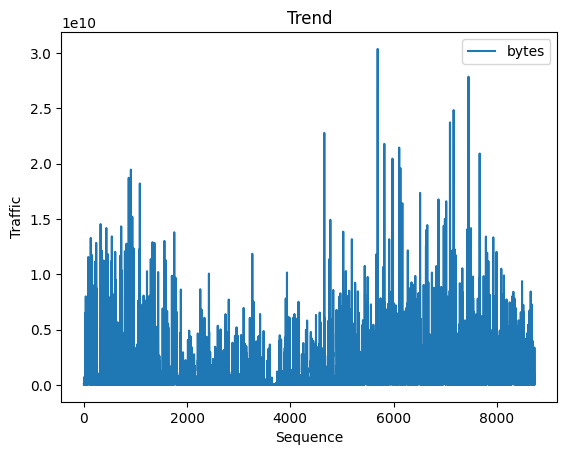

In [60]:
print(y)
plot_line(x, y)


# Start to handle the data

Use one device data

In [34]:
data = pandas.read_csv('fab3b274-1e0c-11ea-928d-06c76ccad02e.csv')
  
# Exclude datetime column
data_values = data.drop('Hour_stamp', axis=1).values
  
# Convert data to float type
data_values = data_values.astype('float32')
  
# Create new dataframe with converted values
data_converted = pandas.DataFrame(data_values,  columns=data.columns[1:])
  
# Add back datetime column
data_converted.insert(0, 'Hour_stamp',  data['Hour_stamp'])

print(data_converted)

          Hour_stamp   Day  Week_of_day  Hour      traffic
0     /2022-07-31 07  31.0          6.0   7.0   74847136.0
1     /2022-07-31 08  31.0          6.0   8.0   39206856.0
2     /2022-07-31 09  31.0          6.0   9.0   28005940.0
3     /2022-07-31 10  31.0          6.0  10.0   32061552.0
4     /2022-07-31 11  31.0          6.0  11.0   50585056.0
...              ...   ...          ...   ...          ...
8732  /2023-07-30 03  30.0          6.0   3.0  142490976.0
8733  /2023-07-30 04  30.0          6.0   4.0   64156556.0
8734  /2023-07-30 05  30.0          6.0   5.0   16177382.0
8735  /2023-07-30 06  30.0          6.0   6.0   94670840.0
8736  /2023-07-30 07  30.0          6.0   7.0  386245344.0

[8737 rows x 5 columns]


Convert data into tensors

In [36]:
data_tensor = tensorflow.convert_to_tensor(data_converted.drop('Hour_stamp', axis=1).values, dtype=tensorflow.float32)
# data_tensor = tf.convert_to_tensor(data_converted, dtype=tf.float32)
print(dir(data_tensor))
data_tensor.shape  
print(data_converted.drop('Hour_stamp', axis=1).values)
# print(data_converted[1][0])
print(data_converted.shape[1])
print(data_converted.shape)

['OVERLOADABLE_OPERATORS', '_USE_EQUALITY', '__abs__', '__add__', '__and__', '__array__', '__array_priority__', '__bool__', '__class__', '__complex__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__div__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__iter__', '__le__', '__len__', '__long__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__nonzero__', '__or__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rmatmul__', '__rmod__', '__rmul__', '__ror__', '__round__', '__rpow__', '__rsub__', '__rtruediv__', '__rxor__', '__setattr__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__tf_tensor__', '__tf_tracing_type__', '__truediv__', '__weakref__', '__xor__', '_add_consumer', '

# Build model

In [43]:
input_dim = data_converted.shape[1] - 1
encoding_dim = 10
  
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
  
# Compile and fit the model
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data_tensor, data_tensor, epochs=100,
                batch_size=32, shuffle=True)
  
# Calculate the reconstruction error for each data point
reconstructions = autoencoder.predict(data_tensor)
mse = tensorflow.reduce_mean(tensorflow.square(data_tensor - reconstructions),
                     axis=1)
anomaly_scores = pandas.Series(mse.numpy(), name='anomaly_scores')
anomaly_scores.index = data_converted.index

Epoch 1/100
274/274 [==============================] - 1s 1ms/step - loss: 692280558394277888.0000
Epoch 2/100
274/274 [==============================] - 0s 1ms/step - loss: 50763837674094592.0000
Epoch 3/100
274/274 [==============================] - 0s 949us/step - loss: 311542432137216.0000
Epoch 4/100
274/274 [==============================] - 0s 978us/step - loss: 180579368960.0000
Epoch 5/100
274/274 [==============================] - 0s 945us/step - loss: 13093830.0000
Epoch 6/100
274/274 [==============================] - 0s 971us/step - loss: 778893.0000
Epoch 7/100
274/274 [==============================] - 0s 974us/step - loss: 132308.0469
Epoch 8/100
274/274 [==============================] - 0s 956us/step - loss: 93865.5156
Epoch 9/100
274/274 [==============================] - 0s 989us/step - loss: 86314.7500
Epoch 10/100
274/274 [==============================] - 0s 993us/step - loss: 80090.9141
Epoch 11/100
274/274 [==============================] - 0s 1ms/step - loss: 

# Set the anomaly limit

In [53]:
threshold = anomaly_scores.quantile(0.999)
anomalous = anomaly_scores > threshold
binary_labels = anomalous.astype(int)
precision, recall,\
    f1_score, _ = precision_recall_fscore_support(
        binary_labels, anomalous, average='binary')

In [54]:
test = data_converted['traffic'].values
predictions = anomaly_scores.values
  
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  1.0
Recall:  1.0
F1 Score:  1.0


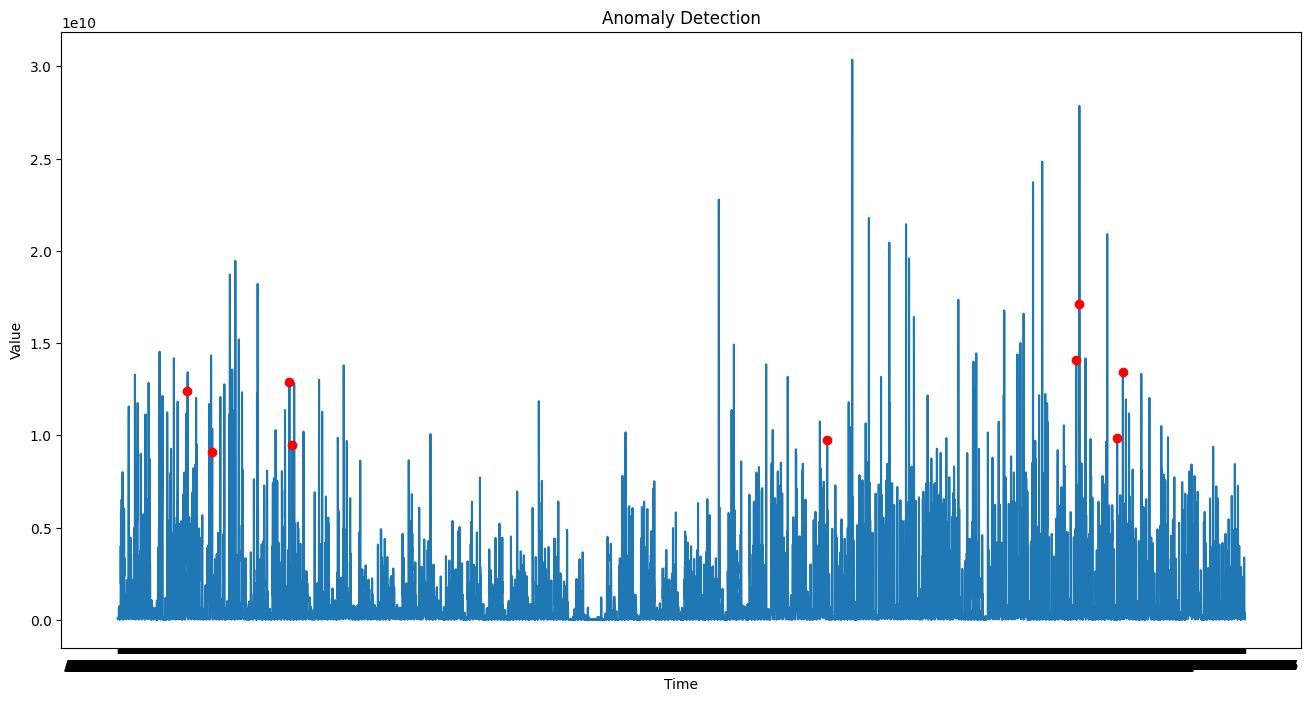

In [59]:
# Plot the data with anomalies marked in red
plt.figure(figsize=(16, 8))
plt.plot(data_converted['Hour_stamp'],
         data_converted['traffic'])
plt.plot(data_converted['Hour_stamp'][anomalous],
         data_converted['traffic'][anomalous], 'ro')
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()